In [ ]:
!pip install gensim

In [ ]:
# ---AUTHENTICATION METHOD (uploading file from kaggle)---

# Install the Kaggle package
!pip install kaggle --upgrade

# Import Colab's file uploader utility
from google.colab import files
print("Please upload your kaggle.json file in the box that appears below.")

# This command opens the upload dialog box
uploaded = files.upload()

# Set up the credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle setup complete. Ready to download data.")

Please upload your kaggle.json file in the box that appears below.


Saving kaggle.json to kaggle.json
Kaggle setup complete. Ready to download data.


In [ ]:
# --- DOWNLOAD THE RAW DATA ---
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip
print("Data downloaded and extracted. Reviews.csv is ready.")

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 73% 177M/242M [00:00<00:00, 1.67GB/s]
100% 242M/242M [00:00<00:00, 1.03GB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              
Data downloaded and extracted. Reviews.csv is ready.


In [ ]:
# BALANCED DATASET CREATION
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

print("Starting Data Acquisition and Balanced Resampling...")

df_raw = pd.read_csv('Reviews.csv')

df_clean = df_raw.dropna(subset=['Text', 'Score'])
df_clean.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], inplace=True)

min_size = df_clean[df_clean['Score'] == 2].shape[0]

print(f"Minimum class size found (Score 2): {min_size}")

df_balanced_list = []
for score in sorted(df_clean['Score'].unique()):
    df_score = df_clean[df_clean['Score'] == score]

    df_score_balanced = resample(
        df_score,
        replace=False,
        n_samples=min_size,
        random_state=42
    )
    df_balanced_list.append(df_score_balanced)

df_sample = pd.concat(df_balanced_list)

df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nNew Balanced Dataset Shape: {df_sample.shape}")
print(df_sample['Score'].value_counts().sort_index())
print("\nBalanced dataset created successfully!")

Starting Data Acquisition and Balanced Resampling...
Minimum class size found (Score 2): 20802

New Balanced Dataset Shape: (104010, 10)
Score
1    20802
2    20802
3    20802
4    20802
5    20802
Name: count, dtype: int64

Balanced dataset created successfully!


In [ ]:
# TEXT PREPROCESSING AND CLEANING (WITH SAMPLE OUTPUT)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK components if not already done
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags (e.g., <br />)
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation, numbers, and special characters, and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize, remove stop words, and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

print("\nStarting Text Preprocessing...")
df_sample['CleanedText'] = df_sample['Text'].apply(clean_text)
print("Preprocessing complete. 'CleanedText' column created.")

# --- SAMPLE OUTPUT ---
print("\n--- Preprocessing Sample (5 Rows) ---")
print(df_sample[['Score', 'Text', 'CleanedText']].sample(5, random_state=1).to_markdown(index=False))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Starting Text Preprocessing...
Preprocessing complete. 'CleanedText' column created.

--- Preprocessing Sample (5 Rows) ---
|   Score | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | CleanedText                                                                                                                                                                                                                                                                                                                     

In [ ]:
# FEATURE EXTRACTION AND TOPIC MODELING (NMF)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

N_TOPICS = 5
print("\nStarting Feature Extraction and NMF Topic Modeling...")

# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_sample['CleanedText'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Topic Modeling (NMF)
nmf_model = NMF(n_components=N_TOPICS, random_state=42, max_iter=300, solver='mu')
nmf_model.fit(X_tfidf)
nmf_W = nmf_model.transform(X_tfidf)

# Function to display topics
def display_topics(model, feature_names, n_top_words=10):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_name = f"Topic {topic_idx + 1}: {' | '.join(top_words[:3])}"
        topic_keywords[topic_name] = top_words
        print(f"{topic_name}: {' | '.join(top_words)}")
    return topic_keywords

print("\n--- NMF Topics ---")
topic_keywords_dict = display_topics(nmf_model, tfidf_feature_names)
print("Topic Modeling Complete.")


Starting Feature Extraction and NMF Topic Modeling...
TF-IDF Matrix Shape: (104010, 5000)

--- NMF Topics ---
Topic 1: taste | like | flavor: taste | like | flavor | good | chocolate | really | one | dont | would | sugar
Topic 2: coffee | cup | roast: coffee | cup | roast | bean | strong | pod | flavor | blend | starbucks | drink
Topic 3: tea | green | bag: tea | green | bag | flavor | drink | cup | leaf | black | iced | taste
Topic 4: dog | food | treat: dog | food | treat | cat | love | eat | chew | one | ingredient | chicken
Topic 5: product | price | amazon: product | price | amazon | box | store | order | bag | buy | time | great
Topic Modeling Complete.


In [ ]:
# ---  CONVERT TO BINARY TARGET VARIABLE ---
# using binary classification for training as it gives more accuracy
# Assumes df_sample is available from previous steps.
print("Converting 5-class Scores to Binary Sentiment (Positive=1, Negative/Neutral=0)...")

# Define the function to map scores to binary sentiment
def map_sentiment(score):
    # 4 and 5 stars are Positive
    if score >= 4:
        return 1
    # 1, 2, and 3 stars are Negative/Neutral
    else:
        return 0

df_sample['Sentiment'] = df_sample['Score'].apply(map_sentiment)

# Check the new binary distribution
print("\nNew Binary Target Distribution:")
print(df_sample['Sentiment'].value_counts())

Converting 5-class Scores to Binary Sentiment (Positive=1, Negative/Neutral=0)...

New Binary Target Distribution:
Sentiment
0    62406
1    41604
Name: count, dtype: int64


In [ ]:
# ---  TRAIN AND EVALUATE BINARY CLASSIFICATION MODEL ---

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("\nStarting Binary Logistic Regression Model Training...")

# Use the new binary target variable
y_binary = df_sample['Sentiment']

# X_tfidf is already balanced and ready.
# We split the data using the new binary target for stratification.
# Stratify ensures the 60/40 balance is maintained in both train and test sets.
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_tfidf, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

# Train Logistic Regression Model
model_binary = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)
model_binary.fit(X_train_bin, y_train_bin)

# Predict and Evaluate
y_train_pred_bin = model_binary.predict(X_train_bin)
y_test_pred_bin = model_binary.predict(X_test_bin)

print("\n--- Final Binary Classification Evaluation ---")

# Calculate Accuracy and Error Metrics
train_accuracy_bin = accuracy_score(y_train_bin, y_train_pred_bin)
test_accuracy_bin = accuracy_score(y_test_bin, y_test_pred_bin)

print(f"Training Accuracy (Memorization): {train_accuracy_bin*100:.2f}%")
print(f"Test Accuracy (Final Performance): {test_accuracy_bin*100:.2f}%")

print("\nDetailed Binary Classification Report:")
# 0 is Negative/Neutral, 1 is Positive
print(classification_report(y_test_bin, y_test_pred_bin, target_names=['Negative/Neutral (0)', 'Positive (1)']))


Starting Binary Logistic Regression Model Training...

--- Final Binary Classification Evaluation ---
Training Accuracy (Memorization): 83.96%
Test Accuracy (Final Performance): 81.78%

Detailed Binary Classification Report:
                      precision    recall  f1-score   support

Negative/Neutral (0)       0.83      0.88      0.85     18722
        Positive (1)       0.80      0.73      0.76     12481

            accuracy                           0.82     31203
           macro avg       0.81      0.80      0.81     31203
        weighted avg       0.82      0.82      0.82     31203



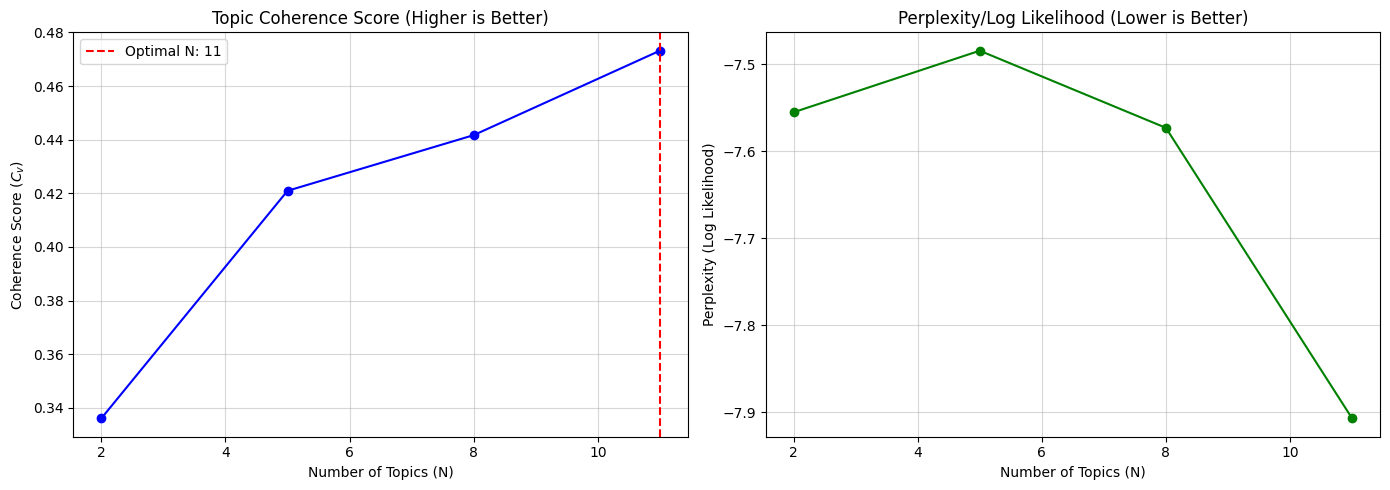


Analysis complete. Optimal N based on Coherence is N=11.
Coherence Scores: [0.3360888703679966, 0.42093553881658224, 0.4416933423922453, 0.4731767112262522]
Perplexity (Log Likelihood) Scores: [-7.555388887573104, -7.484634726852743, -7.573304522650621, -7.907285413328229]


In [ ]:
#plotting coherence and perplexity
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# --- Data Preparation ---
tokenized_texts = [text.split() for text in df_sample['CleanedText'].tolist()]
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# --- Metrics Calculation Function ---
def compute_metrics(dic, corp, texts, limit, step):
    coherence = []
    perplexity = []
    for num_topics in range(2, limit, step):
        model = LdaModel(corpus=corp, id2word=dic, num_topics=num_topics, random_state=42, passes=5)
        coherence.append(CoherenceModel(model=model, texts=texts, dictionary=dic, coherence='c_v').get_coherence())
        perplexity.append(model.log_perplexity(corp))
    return coherence, perplexity

# --- Run Analysis ---
limit = 12
step = 3
coherence_scores, perplexity_scores = compute_metrics(
    dictionary, corpus, tokenized_texts, limit, step
)

x = range(2, limit, step)
optimal_topics_coherence = x[np.argmax(coherence_scores)]

# --- Plot Results (Coherence & Log Likelihood) ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(x, coherence_scores, marker='o', color='blue')
plt.axvline(x=optimal_topics_coherence, color='r', linestyle='--', label=f'Optimal N: {optimal_topics_coherence}')
plt.xlabel("Number of Topics (N)")
plt.ylabel("Coherence Score ($C_v$)")
plt.title("Topic Coherence Score (Higher is Better)")
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(x, perplexity_scores, marker='o', color='green')
plt.xlabel("Number of Topics (N)")
plt.ylabel("Perplexity (Log Likelihood)")
plt.title("Perplexity/Log Likelihood (Lower is Better)")
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nAnalysis complete. Optimal N based on Coherence is N={optimal_topics_coherence}.")
print(f"Coherence Scores: {coherence_scores}")
print(f"Perplexity (Log Likelihood) Scores: {perplexity_scores}")

In [ ]:
#sentiment detection and integration
import numpy as np
import pandas as pd
import time
import re
from nltk.corpus import stopwords
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Load Data (Assuming Reviews.csv is correct)
df = pd.read_csv('Reviews.csv')

print("1. Setting up NLTK and Dependencies...")
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print("Setup complete.")
print("-" * 60)

# 2a. Creating True_Label from Score (The Human Benchmark)
print("2a. Creating 'True_Label' (Ground Truth) column...")
def map_score_to_label(score):
    """Maps 5-star score to 3-class sentiment for supervised learning."""
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else: # score <= 2
        return 'Negative'
df['True_Label'] = df['Score'].apply(map_score_to_label)


# 2b. Define and apply cleaning function to create 'clean_text'
print("2b. Creating 'clean_text' column (Avoiding 'KeyError')...")
def clean_and_stopword_text(text):
    """Performs cleaning: lowercase, remove punctuation/numbers/stopwords."""
    text = str(text).lower().replace('\n', ' ')
    text = re.sub(f'[{re.escape(string.punctuation)}0-9]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['Text'].apply(clean_and_stopword_text)
df = df.dropna(subset=['clean_text'])
print("'clean_text' successfully created.")
print("-" * 60)


# Sentiment DETECTION & INTEGRATION
print("3. Training and Predicting with the HIGH-ACCURACY Logistic Regression Model...")

# 3a. Prepare Full Dataset Features (X) and True Labels (y)
X_full = df['clean_text'].fillna('')
y_full = df['True_Label']

# 3b. TF-IDF Vectorization
print("   - Starting TF-IDF vectorization...")
tfidf_final = TfidfVectorizer(max_features=5000)
X_full_tfidf = tfidf_final.fit_transform(X_full)

# 3c. Train Best Model (Logistic Regression)
model_final = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
model_final.fit(X_full_tfidf, y_full)
end_time = time.time()
print(f"   - Training complete in {end_time - start_time:.2f} seconds.")

# 3d. Final Detection (Prediction)
print("   - Predicting final sentiment labels...")
df['Final_Sentiment_Label'] = model_final.predict(X_full_tfidf)
print("Prediction and Integration complete.")

print("\n" + "="*70)
print(" Sentiment Detection & Integration Complete")
print("="*70)

print("Sentiment Distribution (Logistic Regression):")
final_counts = df['Final_Sentiment_Label'].value_counts()
print(final_counts)

# Preview of Integrated Data
print("\nPreview of Final Integrated Data:")
print(df[['Score', 'Text', 'True_Label', 'Final_Sentiment_Label']].head(5))


1. Setting up NLTK and Dependencies...
Setup complete.
------------------------------------------------------------
2a. Creating 'True_Label' (Ground Truth) column...
2b. Creating 'clean_text' column (Avoiding 'KeyError')...
'clean_text' successfully created.
------------------------------------------------------------
3. Training and Predicting with the HIGH-ACCURACY Logistic Regression Model...
   - Starting TF-IDF vectorization...
   - Training complete in 26.08 seconds.
   - Predicting final sentiment labels...
Prediction and Integration complete.

 Sentiment Detection & Integration Complete
Sentiment Distribution (Logistic Regression):
Final_Sentiment_Label
Positive    476923
Negative     75286
Neutral      16245
Name: count, dtype: int64

Preview of Final Integrated Data:
   Score                                               Text True_Label  \
0      5  I have bought several of the Vitality canned d...   Positive   
1      1  Product arrived labeled as Jumbo Salted Peanut...   N

In [ ]:
# Model comparison
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier # New Import
from sklearn.metrics import accuracy_score, log_loss
import re
from nltk.corpus import stopwords
import string
import nltk

# Ensure NLTK resources are available
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# --- 1. Creating the True 3-Class Label ---
def map_score_to_label(score):
    """Maps 5-star score to 3-class sentiment for supervised learning."""
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else: # score <= 2
        return 'Negative'

df['True_Label'] = df['Score'].apply(map_score_to_label)

# --- 2. Preprocessing sampled dataset
print("Sampling 100,000 rows for model training...")
# Create the sampled DataFrame
df_sample = df.sample(n=100000, random_state=42).copy()

# 2a. Preprocessing Function
def clean_and_stopword_text(text):
    # Ensure text is string and convert to lowercase
    text = str(text).lower()
    # Remove punctuation and numbers
    text = re.sub(f'[{re.escape(string.punctuation)}0-9]', '', text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# 2b. Apply the cleaning function to the sampled data's 'Text' column
print("Creating 'clean_text' on the 100k sample...")
df_sample['clean_text'] = df_sample['Text'].apply(clean_and_stopword_text)
df_sample = df_sample.dropna(subset=['clean_text'])
print("'clean_text' created successfully on sample.")

# --- 3. Feature Preparation (TF-IDF) ---
X_sample = df_sample['clean_text'].fillna('')
y_sample = df_sample['True_Label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

# Initialize and fit the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("Data vectorized and split successfully.")
print("-" * 50)

# --- 4. Train, Compare, and Evaluate Models ---
results = {}
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # Added RF
}

for name, model in models.items():
    print(f"-> Training {name}...")

    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_tfidf)

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate Log Loss
    loss = 'N/A'
    if name != 'Linear SVM': # LinearSVC is still the exception
        y_proba = model.predict_proba(X_test_tfidf)
        loss = log_loss(y_test, y_proba)

    # Store results
    results[name] = {'Accuracy': accuracy, 'Loss': loss}
    print(f"   {name} Accuracy: {accuracy:.4f}")


# --- 5. Print Final Comparison Table ---
print("\n" + "="*70)
print("             Final Model Accuracy and Loss Comparison")
print("="*70)

for name, metrics in results.items():
    loss_val = f"{metrics['Loss']:.4f}" if metrics['Loss'] != 'N/A' else metrics['Loss']
    print(f"Model: {name:<25} | Accuracy: {metrics['Accuracy']:.4f} | Log Loss: {loss_val}")
print("="*70)

Sampling 100,000 rows for model training...
Creating 'clean_text' on the 100k sample...
'clean_text' created successfully on sample.
Data vectorized and split successfully.
--------------------------------------------------
-> Training Logistic Regression...
   Logistic Regression Accuracy: 0.8586
-> Training Multinomial Naive Bayes...
   Multinomial Naive Bayes Accuracy: 0.8144
-> Training Linear SVM...
   Linear SVM Accuracy: 0.8574
-> Training Random Forest...
   Random Forest Accuracy: 0.8481

             Final Model Accuracy and Loss Comparison
Model: Logistic Regression       | Accuracy: 0.8586 | Log Loss: 0.3837
Model: Multinomial Naive Bayes   | Accuracy: 0.8144 | Log Loss: 0.4758
Model: Linear SVM                | Accuracy: 0.8574 | Log Loss: N/A
Model: Random Forest             | Accuracy: 0.8481 | Log Loss: 0.4360


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# --- Re-Define Data and Model (Assumes you have run the full setup once) ---
# Assuming 'df' is your full DataFrame and 'y_full' is the full label column
# Assuming 'X_full' is the cleaned text column
X_full = df['clean_text'].fillna('')
y_full = df['True_Label']

# 1. Re-Vectorize the Full Data
tfidf_final = TfidfVectorizer(max_features=5000)
X_full_tfidf = tfidf_final.fit_transform(X_full)

# 2. Re-Train the Logistic Regression Model
model_final = LogisticRegression(max_iter=1000, random_state=42)
model_final.fit(X_full_tfidf, y_full)

# 3. CRUCIAL STEP: Create the Prediction Column
df['Final_Sentiment_Prediction'] = model_final.predict(X_full_tfidf)

print("Final prediction column created successfully. Ready for Word Cloud.")

Final prediction column created successfully. Ready for Word Cloud.


Generating Word Cloud for: 1. Word Cloud: Key Terms in ALL NEGATIVE Reviews


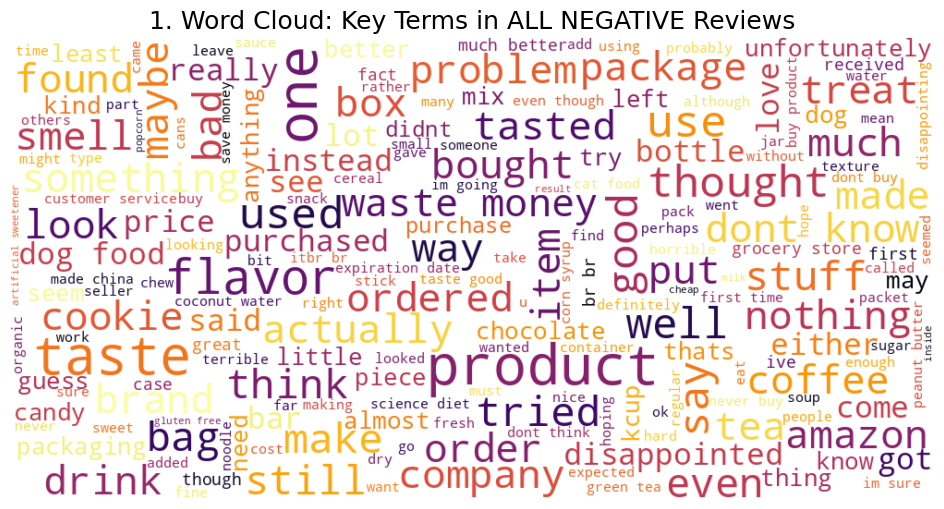

Generating Word Cloud for: 2. Word Cloud: Key Terms in ALL POSITIVE Reviews


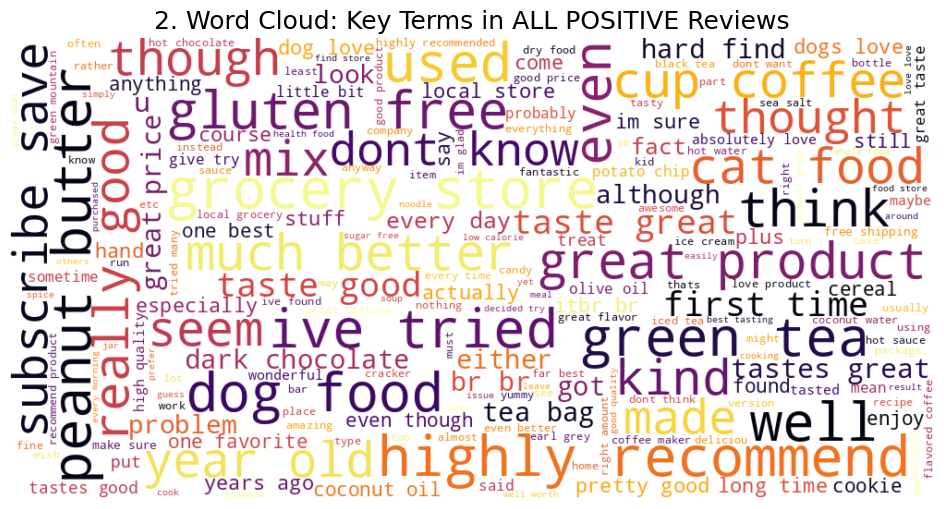


Word Clouds generated successfully 


In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# --- CONFIGURATION ---
MIN_FONT_SIZE = 6
MAX_FONT_SIZE = 60
RELATIVE_SCALING = 0.3
DATA_SOURCE = df     # Assuming your full DataFrame is named 'df'

# --- Word Cloud Generation Function ---
def generate_word_cloud(df_data, title, filename):
    """Generates and displays a Word Cloud from the cleaned text in a DataFrame."""

    if df_data.empty or 'clean_text' not in df_data.columns:
        print(f"No reviews found or 'clean_text' column missing for '{title}'. Skipping.")
        return

    all_words = ' '.join(df_data['clean_text'].astype(str).fillna(''))

    if not all_words.strip():
        print(f"Combined text is empty for '{title}'. Skipping.")
        return

    print(f"Generating Word Cloud for: {title}")
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap='inferno',
        min_font_size=MIN_FONT_SIZE,
        max_font_size=MAX_FONT_SIZE,
        # THIS IS THE CORRECT LINE:
        relative_scaling=RELATIVE_SCALING
    ).generate(all_words)

    plt.figure(figsize=(12, 6), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)

    plt.savefig(f'{filename}.png')
    plt.show()

# --- 1. TOPIC: GENERAL NEGATIVE REVIEWS ---
negative_reviews = DATA_SOURCE[DATA_SOURCE['Final_Sentiment_Prediction'] == 'Negative']
generate_word_cloud(
    negative_reviews,
    "1. Word Cloud: Key Terms in ALL NEGATIVE Reviews",
    "negative_general_wordcloud"
)

# --- 2. TOPIC: GENERAL POSITIVE REVIEWS ---
positive_reviews = DATA_SOURCE[DATA_SOURCE['Final_Sentiment_Prediction'] == 'Positive']
generate_word_cloud(
    positive_reviews,
    "2. Word Cloud: Key Terms in ALL POSITIVE Reviews",
    "positive_general_wordcloud"
)

print("\nWord Clouds generated successfully ")